# Implementation of CoFi for marine traffic modeling

This notebook showcases how to use Consititional Filters (CoFi) in ProMis to improve modeling of ship movements.

## Setup

In [1]:
# This will auto-relead changed ProMis imports
%reload_ext autoreload
%autoreload 2

In [2]:
# We need some additional packages
!pip install -q svgpath2mpl svgpathtools filterpy keplergl

In [3]:
# Standard library
import json
from copy import copy
from math import ceil, isfinite
from pathlib import Path
from time import monotonic
from typing import Any

# Math
import numpy as np
from numpy import array, deg2rad, eye, mean, ndarray, pi, set_printoptions, stack, rad2deg, deg2rad
from numpy.random import seed, standard_normal
from scipy.stats import norm, uniform

# Data Handling
import pandas as pd
from filterpy.monte_carlo import systematic_resample, stratified_resample

# Other Third Party
from rich.progress import track

# Plotting
import matplotlib
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D
from seaborn import move_legend
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
import seaborn as sns

# ProMis
from promis import ProMis, StaRMap
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianRasterBand,
    PolarCollection,
    PolarLocation,
)
from promis.loaders import NauticalChartLoader
from promis.logic.spatial import Depth


In [4]:
# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})

# Make plots look nice in a paper
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"figure.figsize": (10, 4), "legend.title_fontsize": 15})
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

## Define the setting

In [5]:
# The format of the bbox is:
# (lat, lon) lower left, and then
# (lat, lon) upper right

setting = "New York Harbor"
bbox = (
    (40.52, -74.08),
    (40.70, -73.85),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     (32.75, -79.97),
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     (39.174, -76.6304993),
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     (36.7711453, -76.4994133),
#     (37.3020172, -75.8786833),
# )

In [6]:
output_folder = Path(".") / "cofi-exports" / setting
output_folder.mkdir(exist_ok=True, parents=True)

In [7]:
origin = PolarLocation(
    latitude=mean([bbox[0][0], bbox[1][0]]), longitude=mean([bbox[0][1], bbox[1][1]])
)
width = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[0][0], longitude=bbox[1][1])
)
height = PolarLocation(latitude=bbox[0][0], longitude=bbox[0][1]).distance(
    PolarLocation(latitude=bbox[1][0], longitude=bbox[0][1])
)
dimensions = width, height
dimensions

(19490.788929051603, 19988.34793513066)

In [8]:
target_resolution = (200, 200)
support_resolution = (100, 100)

## Load the nautical chart data

Like all somewhat time-consuming steps, this only needs to be done once.

In [9]:
uam_path = Path("nautical_chart_uam.pkl")

if uam_path.exists():
    uam = CartesianMap.load(uam_path)

else:
    loader = NauticalChartLoader(
        chart_root=Path(".").absolute().parent / "data" / "us_charts-ny",
        origin=origin,
        dimensions=dimensions,
    )
    loader.load(n_jobs=16)

    uam = loader.to_cartesian_map()
    uam.apply_covariance(50.0 * eye(2))

    uam.save(uam_path)

print(f"Loaded {len(uam.features)} features")

Loaded 3802 features


In [10]:
# Print the some features
for feature in uam.features[500:1000:31]:  # Get some diversity
    print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

CartesianPolygon - anchorage: 	US5NYCCF#0226118FBFB01C82 (Anchor berth (single)): "G3"
CartesianPolygon - anchorage: 	US5NYCCF#022602C159BB1C82 (Anchor berth (single)): "O5"
CartesianPolygon - anchorage: 	US5NYCCF#022622152D461C82 (Anchor berth (single)): "K10"
CartesianPolygon - anchorage: 	US5NYCCF#022608F3C61E1C82 (Anchor berth (single)): "N6"
CartesianPolygon - anchorage: 	US5NYCCF#0226242A0CDD1C82 (Anchor berth (single)): "I6"
CartesianPolygon - anchorage: 	US5NYCCF#02260B6F82FB1C82 (Anchor berth (single)): "N8"
CartesianPolygon - anchorage: 	US5NYCCF#022639479B711C82 (Anchor berth (single)): "E5"
CartesianPolygon - anchorage: 	US5NYCCF#02263ABB47F41C82 (Anchor berth (single)): "M5"
CartesianPolygon - anchorage: 	US5NYCCF#02261DC124E61C82 (Anchor berth (single)): "F4"
CartesianPolygon - anchorage: 	US5NYCCF#02262DB2D5AE1C82 (Anchor berth (single)): "C9"
CartesianPolygon - anchorage: 	US5NYCCF#022605EDE0241C82 (Anchor berth (single)): "P2"
CartesianPolygon - anchorage: 	US5NYCCF#02

## Prepare the mission landscape

In [11]:
logic_specifics_dummy = r"""
% Perception from sensors
draught ~ normal(3, 0.5).
0.1::anchoring.
0.9::travels_waterways.
"""

logic = r"""
% Background knowledge
sufficient_depth(X) :-
    A is depth(X, water), B is draught,
    A + B < -1.5, \+ over(X, land).

0.95::safe(X) :-
    sufficient_depth(X), distance(X, land) > 50.

proper_anchorage(X) :-
    anchoring, over(X, anchorage);
    \+ anchoring, \+ over(X, anchorage).

0.90::waterway_preference(X) :-
    travels_waterways, distance(X, waterway) < 400;
    \+ travels_waterways.

% Compliance with Constitution
landscape(X) :-
    proper_anchorage(X), safe(X),
    waterway_preference(X).
"""

support = CartesianRasterBand(origin, support_resolution, width, height)
target = CartesianRasterBand(origin, target_resolution, width, height)

In [12]:
starmap_path = Path("maritime_star_map.pkl")

if starmap_path.exists():
    star_map = StaRMap.load(starmap_path)

else:
    # We create a statistical relational map (StaR Map) to represent the
    # stochastic relationships in the environment, computing a raster of 100 x 100 points
    # using linear interpolation of a sample set
    before = monotonic()
    star_map = StaRMap(target, uam, method="nearest")

    star_map.initialize(
        # The sample points for which the relations will be computed directly
        support=support,
        # We now compute the Distance and Over relationships for the selected points
        # For this, we take many random samples from generated/possible map variations
        number_of_random_maps=5,  # TODO
        # The logic used later. This is required to determine which relationships to prepare
        logic=logic + logic_specifics_dummy,
    )
    after = monotonic()

    star_map.save(starmap_path)

    runtime = after - before
    f"Computed StaR Map in {runtime} seconds"


### Visualize the relations

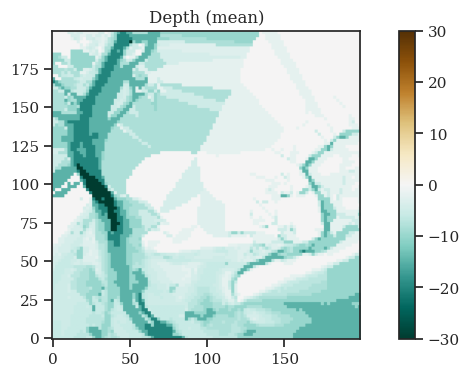

<Figure size 1000x400 with 0 Axes>

In [13]:
# We first plot the depth since we have some special handling for it
depth: Depth = star_map.get("depth", "water")
plt.title("Depth (mean)")
depth.plot(value_index=0)
plt.show()
plt.clf()

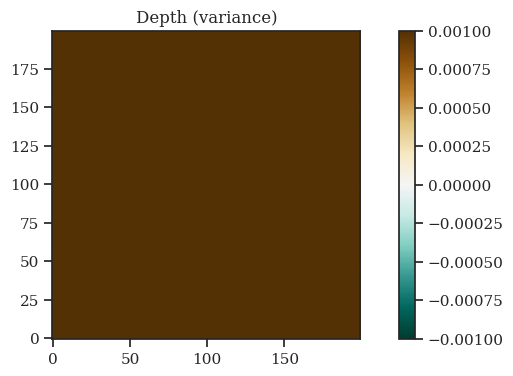

<Figure size 1000x400 with 0 Axes>

In [14]:
plt.title("Depth (variance)")
depth.plot(value_index=1)
plt.show()
plt.clf()

In [15]:
all_relations = star_map.relation_and_location_types
all_relations

{'over': {'anchorage', 'land'},
 'distance': {'land', 'waterway'},
 'depth': {'water'}}

Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)
Lowered zoom level to keep map size reasonable. (z = 12)


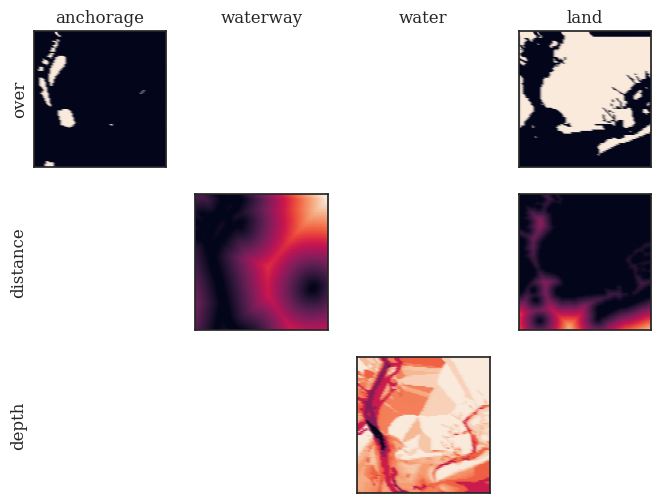

<Figure size 1000x400 with 0 Axes>

In [16]:
# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relations), len(star_map.location_types), figsize=(8, 6), sharex=True, sharey=True
)

for i, (relation_type, location_types) in enumerate(all_relations.items()):
    for j, location_type in enumerate(star_map.location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        if location_type in location_types:
            relation = star_map.get(relation_type, location_type)
            relation.parameters.scatter(ax=ax, alpha=0.5, value_index=0)
        else:
            # No data available, but we still want to show the label
            ax.set_xticks([])
            ax.set_yticks([])
            # Despine
            sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

Lowered zoom level to keep map size reasonable. (z = 12)


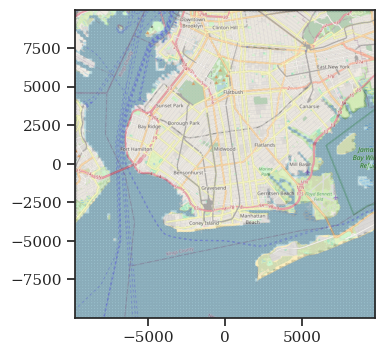

<Figure size 1000x400 with 0 Axes>

In [17]:
relation = star_map.get("over", "land")
relation.parameters.scatter(vmin=0, s=0.1, alpha=0.2)
plt.show()
plt.clf()

In [18]:
folder = output_folder / "relations"
folder.mkdir(exist_ok=True)

for relation_type, location_types in star_map.relation_and_location_types.items():
    for location_type in location_types:
        relation = star_map.get(relation_type, location_type)
        path = folder / f"{relation_type}_{location_type}.csv"
        relation.parameters.to_polar().to_csv(path)

### Run some inference

To make sure everything will run smoothly, we can run some inference on the data.

In [19]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic programs

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)


% Background knowledge
sufficient_depth(X) :-
    A is depth(X, water), B is draught,
    A + B < -1.5, \+ over(X, land).

0.95::safe(X) :-
    sufficient_depth(X), distance(X, land) > 50.

proper_anchorage(X) :-
    anchoring, over(X, anchorage);
    \+ anchoring, \+ over(X, anchorage).

0.90::waterway_preference(X) :-
    travels_waterways, distance(X, waterway) < 400;
    \+ travels_waterways.

% Compliance with Constitution
landscape(X) :-
    proper_anchorage(X), safe(X),
    waterway_preference(X).

% Perception from sensors
draught ~ normal(3, 0.5).
0.1::anchoring.
0.9::travels_waterways.

depth(x_0, water) ~ normal(-6.0, 0.001).
distance(x_0, waterway) ~ normal(3062.361577277537, 0.001).
distance(x_0, land) ~ normal(3731.38903012275, 0.001).
0.0::over(x_0, anchorage).
0.0::over(x_0, land).
query(landscape(x_0)).
depth(x_1, water) ~ normal(-6.0, 0.001).
distance(x_1, waterway) ~ normal(2865.4850686239174, 0.001).
distance(x_1, land) ~ normal(3566.6827659221826, 0.001).
0.0::ove

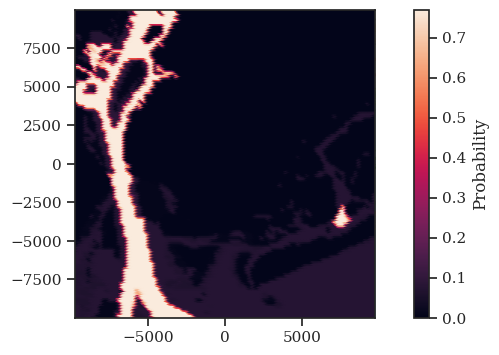

<Figure size 1000x400 with 0 Axes>

In [20]:
# Solve an example logic program
landscape = promis.solve(
    support, logic + logic_specifics_dummy, n_jobs=16, batch_size=3, print_first=True
)

# Show the resulting landscape
ax = landscape.scatter()
plt.colorbar(ax, label="Probability")
plt.show()
plt.clf()

## Load some AIS data

The Automatic Identification System (AIS) is a system used for tracking ships. We will use its observations as our measurements and for model validation.

In [21]:
vessel_types = json.loads((Path("data") / "vessel_types_simplified.json").read_text())

In [22]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    df["is_anchoring"] = df["Status"] == 1

    # Filter out all vessels that have an average SOG of less than 1 knot
    df = df.groupby("MMSI").filter(lambda x: x["SOG"].mean() > 1)

    return df


df = pd.concat(
    [
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox),
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_02.csv", bbox=bbox),
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_03.csv", bbox=bbox),
    ]
)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,is_anchoring
9007215,232040168,2023-08-01 19:06:21,40.52027,-74.03197,8.7,339.7,344.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
6671099,232040168,2023-08-01 19:07:49,40.52332,-74.03350,7.9,336.6,345.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
9009252,232040168,2023-08-01 19:09:19,40.52637,-74.03515,7.9,340.2,349.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
6685546,232040168,2023-08-01 19:10:21,40.52848,-74.03587,8.7,353.3,356.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
6697396,232040168,2023-08-01 19:12:25,40.53272,-74.03660,5.5,344.6,357.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461703,636093148,2023-08-03 04:20:36,40.53343,-74.01964,18.5,143.2,143.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False
1469270,636093148,2023-08-03 04:21:38,40.52939,-74.01512,18.6,136.1,136.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False
1466812,636093148,2023-08-03 04:22:40,40.52575,-74.00995,18.8,127.2,128.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False
6082811,636093148,2023-08-03 04:23:44,40.52275,-74.00377,18.9,118.3,118.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False


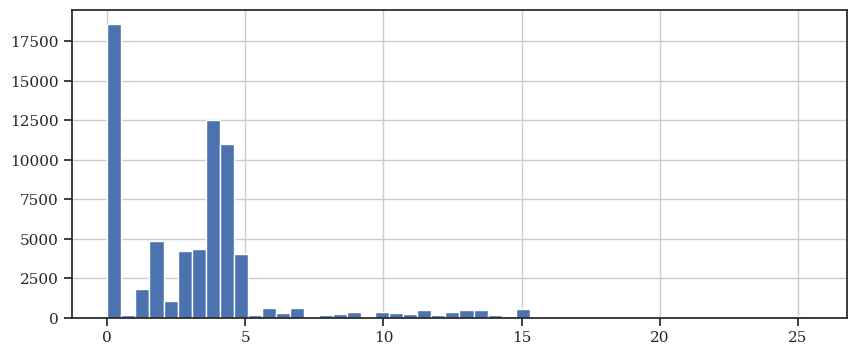

In [23]:
df["Draft"].hist(bins=50)
pass

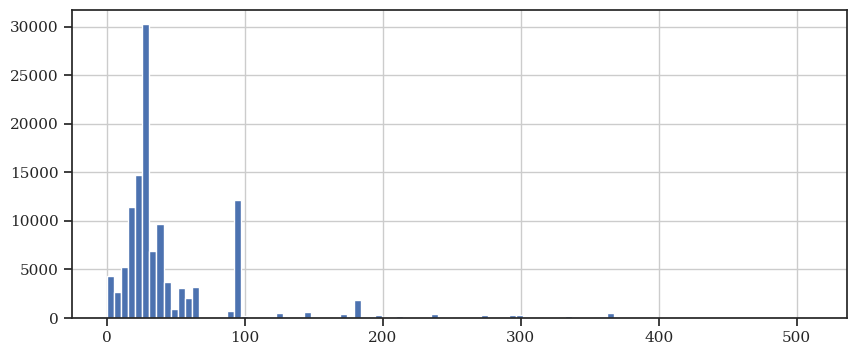

In [24]:
df["Length"].hist(bins=100)
pass

In [25]:
df["Status"].value_counts().sort_index()

Status
0.0     94525
1.0      3547
2.0       353
3.0         7
5.0     11087
6.0       907
7.0        97
8.0       416
9.0       338
11.0      123
12.0     7142
15.0     6560
Name: count, dtype: int64

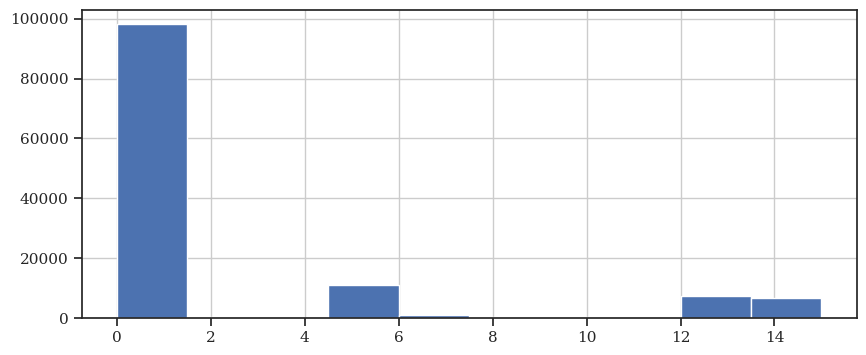

In [26]:
df["Status"].hist()
pass

In [27]:
collection = PolarCollection(origin=origin, number_of_values=0)
collection.append_with_default(df[["LON", "LAT"]].values, value=())
cartesian = collection.to_cartesian()

df.loc[:, "East"] = cartesian.data["east"].values
df.loc[:, "North"] = cartesian.data["north"].values
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,is_anchoring,East,North
9007215,232040168,2023-08-01 19:06:21,40.52027,-74.03197,8.7,339.7,344.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-5675.188325,-9961.958870
6671099,232040168,2023-08-01 19:07:49,40.52332,-74.03350,7.9,336.6,345.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-5804.580884,-9623.172981
9009252,232040168,2023-08-01 19:09:19,40.52637,-74.03515,7.9,340.2,349.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-5944.129822,-9284.376577
6685546,232040168,2023-08-01 19:10:21,40.52848,-74.03587,8.7,353.3,356.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-6004.950390,-9050.023266
6697396,232040168,2023-08-01 19:12:25,40.53272,-74.03660,5.5,344.6,357.0,DANCING BEAR,IMO0000000,MKTD4,...,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft,False,-6066.422330,-8579.143087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461703,636093148,2023-08-03 04:20:36,40.53343,-74.01964,18.5,143.2,143.0,TANGIER EXPRESS,IMO9525900,5LDS8,...,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False,-4629.410780,-8501.329992
1469270,636093148,2023-08-03 04:21:38,40.52939,-74.01512,18.6,136.1,136.0,TANGIER EXPRESS,IMO9525900,5LDS8,...,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False,-4246.705751,-8950.178790
1466812,636093148,2023-08-03 04:22:40,40.52575,-74.00995,18.8,127.2,128.0,TANGIER EXPRESS,IMO9525900,5LDS8,...,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False,-3808.853762,-9354.618008
6082811,636093148,2023-08-03 04:23:44,40.52275,-74.00377,18.9,118.3,118.0,TANGIER EXPRESS,IMO9525900,5LDS8,...,0.0,366.0,48.0,11.5,74.0,A,"Cargo, hazardous",False,-3285.335787,-9688.000792


### Visualize it

In [28]:
MMSIs = df["MMSI"].value_counts()
min_observations = 10 + 20 + 15  # warmup + some usage in between + dead_reckoning
relevant_MMSIs = MMSIs[MMSIs > min_observations].index
df = df[df["MMSI"].isin(relevant_MMSIs)].copy()

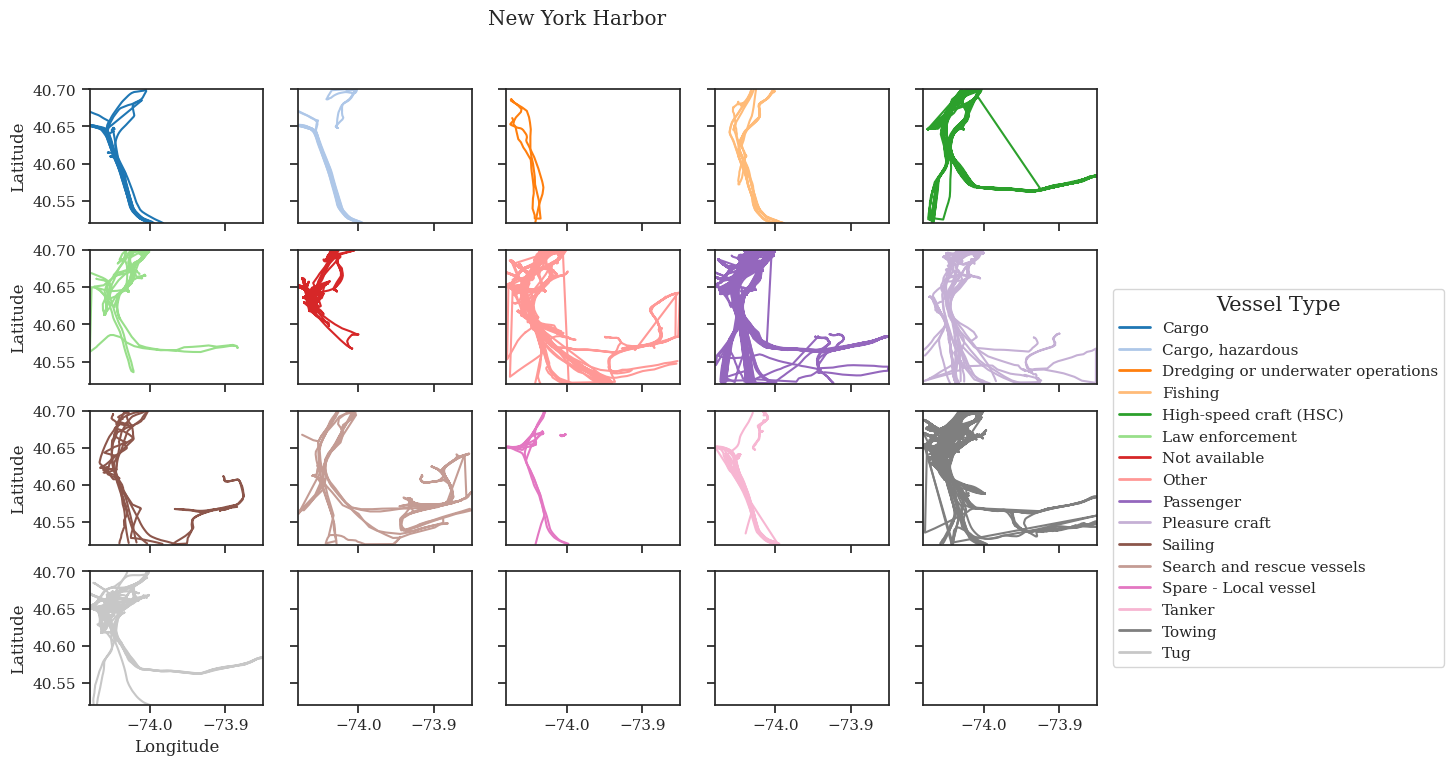

<Figure size 1000x400 with 0 Axes>

In [29]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

all_vessel_types = df["VesselTypeName"].unique()

cols = 5
all_rows = ceil(len(all_vessel_types) / cols)
fig, ax = plt.subplots(ncols=cols, nrows=all_rows, figsize=(13, 8), sharex=True, sharey=True)

for (vessel_type, i), ax in zip(vessel_type_to_index.items(), ax.flatten()):
    for mmsi in relevant_MMSIs:
        df_ = df[df["MMSI"] == mmsi]
        if all_vessel_types is not None and df_["VesselTypeName"].iloc[0] != vessel_type:
            continue
        vessel_type = df_["VesselTypeName"].iloc[0]
        color = palette[vessel_type_to_index[vessel_type]]
        ax.plot(df_["LON"], df_["LAT"], c=color)

    ax.set_xlim(bbox[0][1], bbox[1][1])
    if i >= cols * (all_rows - 1):
        ax.set_xlabel("Longitude")
    ax.set_ylim(bbox[0][0], bbox[1][0])
    if i % cols == 0:
        ax.set_ylabel("Latitude")

    col = i % cols
    row = i // cols
    # if we are in the center, right-hand side
    if col == cols - 1 and row == len(all_vessel_types) // cols - 1:
        ax.legend(
            [
                plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
                for i, vessel_type in enumerate(vessel_type_to_index)
            ],
            vessel_type_to_index.keys(),
            title="Vessel Type",
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
        )

plt.suptitle(setting)

plt.savefig(output_folder / "ais-all-tracks.pdf", bbox_inches="tight")

plt.show()
plt.clf()

In [30]:
relevant_vessel_types = [
    "Cargo",
    "Cargo, hazardous",
    "Search and rescue vessels",
    "Towing",
    "Other",
    "Tanker",
    "Tanker, hazardous",
]

In [31]:
for mmsi in relevant_MMSIs:
    df_ = df[df["MMSI"] == mmsi]
    if df_["VesselTypeName"].iloc[0] not in relevant_vessel_types:
        continue

    plt.plot(df_["LON"], df_["LAT"], c=color)
    plt.xlim(bbox[0][1], bbox[1][1])
    plt.ylim(bbox[0][0], bbox[1][0])
    plt.gca().set_aspect("equal")

    path = output_folder / "plot-individual-traces" / df_["VesselTypeName"].iloc[0]
    path.mkdir(exist_ok=True, parents=True)
    plt.savefig(path / f"{mmsi}.pdf", bbox_inches="tight")
    plt.clf()

<Figure size 1000x400 with 0 Axes>

In [32]:
# An example of a single vessel
track_mmsi = 636017103
track_mmsi

636017103

In [33]:
df_ = df[df["MMSI"] == track_mmsi]
df_

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName,is_anchoring,East,North
8684223,636017103,2023-08-01 12:42:33,40.52173,-73.99979,14.1,297.4,297.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-2948.118757,-9801.407044
4277332,636017103,2023-08-01 12:43:39,40.52370,-74.00477,14.0,297.5,299.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-3370.027333,-9582.470582
4289181,636017103,2023-08-01 12:44:45,40.52617,-74.00927,13.7,313.2,317.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-3751.210309,-9308.008359
4296179,636017103,2023-08-01 12:45:52,40.52931,-74.01278,13.5,322.8,323.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4048.440577,-8959.172452
4301282,636017103,2023-08-01 12:46:58,40.53263,-74.01607,13.6,323.1,323.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4326.991573,-8590.347249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4888223,636017103,2023-08-03 15:51:38,40.53210,-74.01976,12.4,144.9,145.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4639.669594,-8649.013395
4840822,636017103,2023-08-03 15:52:40,40.52912,-74.01689,12.6,142.5,142.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4396.696850,-8980.074135
4848187,636017103,2023-08-03 15:53:50,40.52634,-74.01313,12.3,126.7,124.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-4078.276407,-9288.959375
4857132,636017103,2023-08-03 15:55:50,40.52297,-74.00534,12.3,117.2,117.0,MAERSK SKARSTIND,IMO9740457,D5JH7,...,0.0,300.0,NaN,NaN,71.0,A,Cargo,False,-3418.365037,-9663.511281


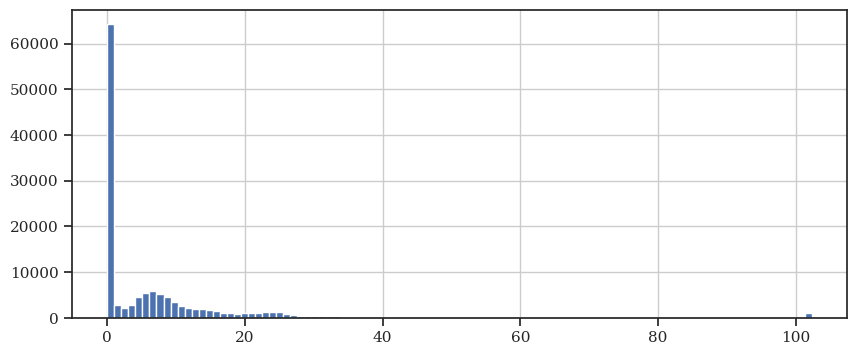

In [34]:
df["SOG"].hist(bins=100)
pass

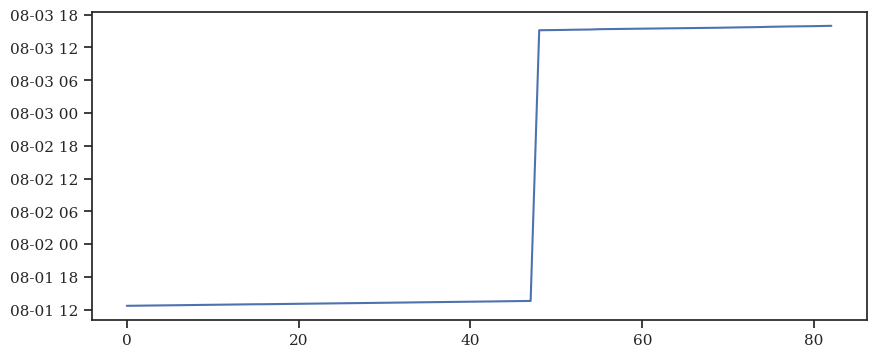

In [35]:
plt.plot(np.arange(len(df_["BaseDateTime"])), df_["BaseDateTime"])
pass

### Provide the trust features to the system

- We can read the categorical AIS class directly from the data.
- We compute the binary `travels_waterways` from a simple heuristic.
- We estimate the continous `anchoring` probability using a machine learning model estimated on a hold-out set of data. 

In [36]:
df["travels_waterways"] = df["VesselTypeName"].isin(
    ["Tanker", "Tanker, hazardous", "Cargo", "Cargo, hazardous"]
) & (df["Length"] >= 50)

df["travels_waterways"].value_counts(dropna=False, normalize=True)

travels_waterways
False    0.965624
True     0.034376
Name: proportion, dtype: float64

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, RobustScaler

anchoring_reg = MLPRegressor(
    hidden_layer_sizes=(200,),
    activation="relu",
    alpha=1e-3,  # L2 regularization
    solver="lbfgs",
    max_iter=1_000,
    random_state=2025,
    tol=1e-3,
    verbose=True,
)

In [38]:
data_reg = pd.concat(
    [
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_02.csv", bbox=bbox),
        load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_03.csv", bbox=bbox),
    ]
)

one_hot_vessel_type = OneHotEncoder()
length_scaler = RobustScaler(with_centering=False)
speed_scaler = RobustScaler(with_centering=False)
is_fitted = False


def df_to_X(df_input: pd.DataFrame) -> np.ndarray:
    vessel_type_name = df_input["VesselTypeName"].to_numpy().reshape(-1, 1)
    length = df_input["Length"].fillna(0).to_numpy().reshape(-1, 1)
    speed = df_input["SOG"].fillna(0).to_numpy().reshape(-1, 1)

    global is_fitted
    if not is_fitted:
        one_hot_vessel_type.fit(vessel_type_name)
        length_scaler.fit(length)
        speed_scaler.fit(speed)

        is_fitted = True

    return np.concatenate(
        [
            one_hot_vessel_type.transform(vessel_type_name).toarray(),
            length_scaler.transform(length),
            speed_scaler.transform(speed),
        ],
        axis=1,
    )


# The input data, also fits the transforms
anchoring_X = df_to_X(data_reg)
# The target data
anchoring_y = data_reg["is_anchoring"].to_numpy().astype("float64")

anchoring_X.shape, anchoring_y.shape

((88555, 19), (88555,))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(anchoring_X, anchoring_y, random_state=2025)
anchoring_reg.fit(X_train, y_train)
mean_absolute_error(y_test, anchoring_reg.predict(X_test))

0.04006043728383986

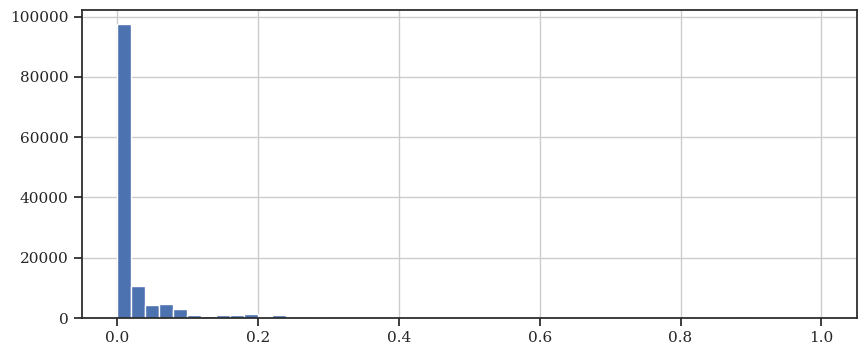

In [40]:
df["is_anchoring_learnt"] = anchoring_reg.predict(df_to_X(df)).clip(0, 1)
df["is_anchoring_learnt"].hist(bins=50)
pass

In [41]:
data_reg["is_anchoring"].value_counts(normalize=True)

is_anchoring
False    0.97038
True     0.02962
Name: proportion, dtype: float64

## Compute the ProMis landscapes for the ship categories

In [42]:
def landscape_for_mmsi(
    mmsi: int,
    where: CartesianCollection | np.ndarray | None = None,
    n_jobs: int = 16,
    batch_size: int = 10,
    return_time=False,
) -> CartesianCollection:
    # For simplicity, we extract the metadata of the first observation
    metadata = df[df["MMSI"] == mmsi].iloc[0]

    specific = copy(logic)

    # % Perception from sensors
    # draught ~ normal(3, 0.5).
    # 0.1::anchoring.
    # 0.9::travels_waterways.

    # % Background knowledge
    # sufficient_depth(X) :-
    #     A is depth(X, water), B is draught,
    #     A + B < -1.5, \+ over(X, land).

    # 0.95::safe(X) :-
    #     sufficient_depth(X), distance(X, land) > 50.

    # proper_anchorage(X) :-
    #     anchoring, over(X, anchorage);
    #     \+ anchoring, \+ over(X, anchorage).

    # 0.90::waterway_preference(X) :-
    #     travels_waterways, distance(X, waterway) < 400;
    #     \+ travels_waterways.

    # % Compliance with Constitution
    # landscape(X) :-
    #     proper_anchorage(X), safe(X),
    #     waterway_preference(X).

    vessel_type = metadata["VesselTypeName"].replace(" ", "_").lower()
    specific += f"\nis_{vessel_type}."
    for vessel_type in relevant_vessel_types:
        if vessel_type != metadata["VesselTypeName"]:
            # For clarity, we add a negative fact for all other vessel types
            specific += f"\n0.0::is_{vessel_type.lower().replace(' ', '_').replace(',', '_')}."

    # length = metadata["Length"]
    # if isfinite(length) and length > 0:
    #     specific += f"\nlength ~ normal({length}, {length * 0.05})."
    # else:
    #     # Some prior knowledge
    #     specific += "\nlength ~ normal(30, 10)."

    if metadata["travels_waterways"]:
        specific += "\n0.9::travels_waterways."
    else:
        specific += "\n0.1::travels_waterways."

    probability_is_anchoring = metadata["is_anchoring_learnt"]
    specific += f"\n{probability_is_anchoring}::anchoring."

    draught = metadata["Draft"]
    if isfinite(draught) and draught > 0:
        specific += f"\ndraught ~ normal({draught}, {abs(draught) * 0.1})."
    else:
        # Some prior knowledge
        specific += "\ndraught ~ normal(2, 1)."

    specific += "\n\n"  # Add newlines for better readability

    if where is None:
        specific_support = support
    else:
        if isinstance(where, np.ndarray):
            specific_support = CartesianCollection(origin=origin, number_of_values=0)
            specific_support.append_with_default(where, value=())
        else:
            specific_support = where

    before = monotonic()
    res = promis.solve(
        specific_support,
        specific,
        n_jobs=n_jobs,
        batch_size=batch_size,
        show_progress=False,
        print_first=False,
    )
    after = monotonic()

    if return_time:
        return res, after - before
    return res


landscapes = {
    "Cargo": landscape_for_mmsi(636017103),
    "Search and rescue vessels": landscape_for_mmsi(367531710),
    "Towing": landscape_for_mmsi(303461000),
}

In [43]:
landscapes["Cargo"].save(output_folder / "landscape-cargo.pkl")

In [44]:
time = []

the_support = CartesianRasterBand(origin, (20, 10), width, height)

for _ in range(5):
    _, diff = landscape_for_mmsi(
        636017103, where=the_support, n_jobs=16, batch_size=5, return_time=True
    )
    time.append(diff)

np.mean(time).item(), np.std(time).item()

(6.577459542997531, 0.28954967860355385)

### Save them for external use

In [45]:
for vessel_type, landscape in landscapes.items():
    # Store the landscape
    path = output_folder / "landscape"
    path.mkdir(exist_ok=True)
    landscape.to_polar().to_csv(path / f"{vessel_type}.csv")

    # Store the trace of the vessels
    df_ = df[df["VesselTypeName"] == vessel_type]
    path = output_folder / "ais-trace"
    path.mkdir(exist_ok=True)
    df_[["MMSI", "LAT", "LON"]].to_csv(path / f"{vessel_type}.csv", index=False)

### Visualize the landscapes

In [46]:
# This will be used much later
ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

Lowered zoom level to keep map size reasonable. (z = 12)


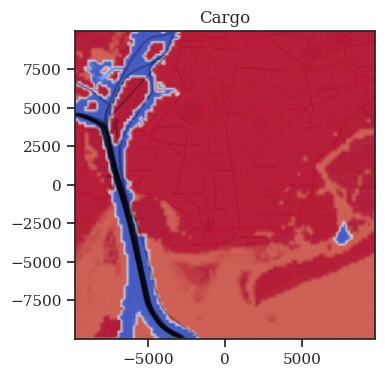

Lowered zoom level to keep map size reasonable. (z = 12)


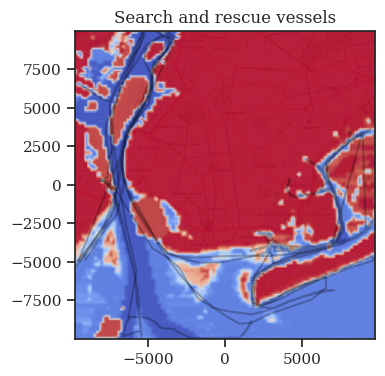

Lowered zoom level to keep map size reasonable. (z = 12)


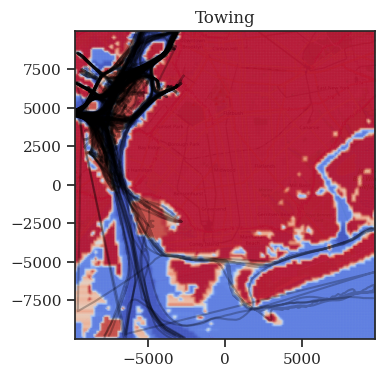

<Figure size 1000x400 with 0 Axes>

In [47]:
for vessel_type, landscape in landscapes.items():
    landscape.scatter(s=2, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.35)

    df_ = df[df["VesselTypeName"] == vessel_type]
    for mmsi in df_["MMSI"].unique():
        df__ = df_[df_["MMSI"] == mmsi]
        plt.plot(df__["East"], df__["North"], c="black", alpha=0.25)

    plt.title(vessel_type)
    plt.show()
    plt.clf()

Lowered zoom level to keep map size reasonable. (z = 12)


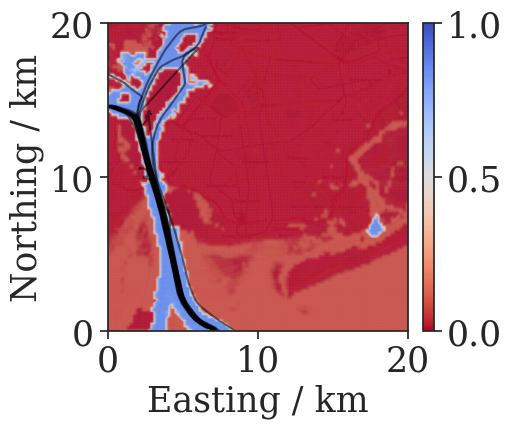

Lowered zoom level to keep map size reasonable. (z = 12)


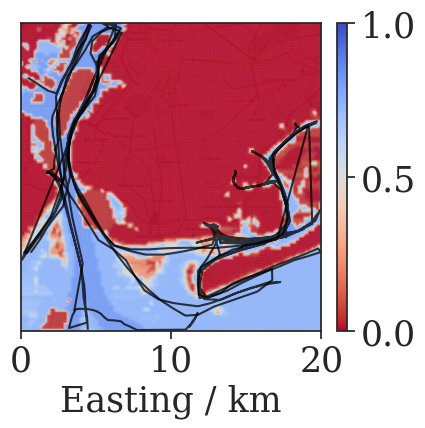

Lowered zoom level to keep map size reasonable. (z = 12)


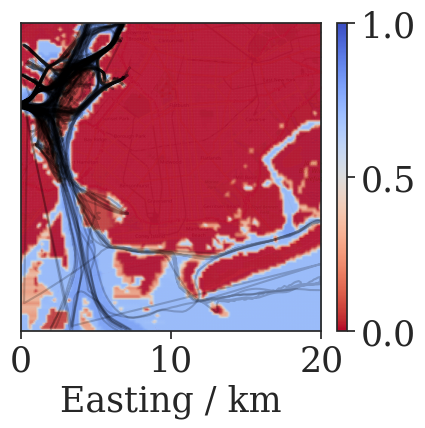

In [48]:
def export(vessel_type, name, alpha, y_axis=True):
    landscape = landscapes[vessel_type]
    image = landscape.scatter(
        s=2, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.35, vmax=1
    )

    df_ = df[df["VesselTypeName"] == vessel_type]
    for mmsi in df_["MMSI"].unique():
        df__ = df_[df_["MMSI"] == mmsi]
        plt.plot(df__["East"], df__["North"], c="black", alpha=alpha)
        # plt.scatter(df__["East"], df__["North"], c=df__["North"], s=1)

    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
    cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
    cbar.ax.tick_params(labelsize=25)
    cbar.solids.set(alpha=1)

    height, width = landscape.dimensions

    xticks = [-height / 2, 0, height / 2]
    yticks = [-width / 2, 0, width / 2]
    labels = ["0", "10", "20"]

    plt.xlabel("Easting / km", fontsize=25)
    plt.xticks(xticks, labels, fontsize=25)

    if y_axis:
        plt.ylabel("Northing / km", fontsize=25)
        plt.yticks(yticks, labels, fontsize=25)
    else:
        plt.ylabel("")
        plt.yticks([], [])

    # plt.xlim([-width / 2, width / 2])
    # plt.ylim([-height / 2, height / 2])
    plt.savefig(name, bbox_inches="tight")
    plt.show()


export("Cargo", name=output_folder / "Cargo.pdf", alpha=0.5)
export(
    "Search and rescue vessels",
    name=output_folder / "Search and rescue vessels.pdf",
    alpha=0.75,
    y_axis=False,
)
export("Towing", name=output_folder / "Towing.pdf", alpha=0.2, y_axis=False)

In [49]:
interpolators = {
    vessel_type: landscape.get_interpolator(method="linear")
    for vessel_type, landscape in landscapes.items()
}

In [50]:
typical_ship_speed = 5  # meters per second
typical_sample_time = 60  # seconds

In [51]:
def plot_trajectories(all_positions: ndarray, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

Lowered zoom level to keep map size reasonable. (z = 12)


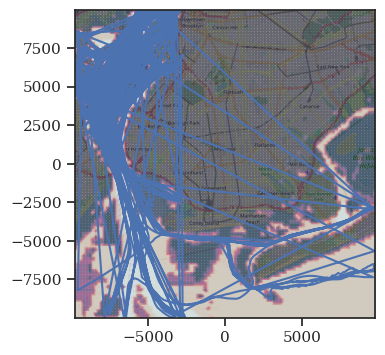

<Figure size 1000x400 with 0 Axes>

In [52]:
plt.figure(figsize=(6, 4))
landscape.scatter(s=0.2, alpha=0.5)
positions = stack((df_["East"], df_["North"])).T
plot_trajectories(positions, label="True trajectory")
plt.show()
plt.clf()
pass

In [53]:
def plot_trajectories_animated(positions: ndarray, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions.T), label="Ship Position")

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(positions)

## Implement CoFi using a particle filter

We directly define the experiments that we will run.

In [ ]:
def run_experiment(
    ship_df: pd.DataFrame,
    seed_value: int = 2024,
    constitutional_trust: float = 0.8,
    interpolator: Any | None = None,
) -> pd.DataFrame:
    def create_initial_particles(N: int) -> ndarray:
        typical_ship_speed = 8
        return np.stack(
            [
                uniform(loc=-width / 2, scale=width).rvs(N),  # x position (east)
                uniform(loc=-height / 2, scale=height).rvs(N),  # y position (north)
                # uniform(loc=0, scale=2 * pi).rvs(N),  # heading
                # norm(loc=5, scale=3).rvs(N),  # speed
                norm(loc=0, scale=typical_ship_speed).rvs(N),
                norm(loc=0, scale=typical_ship_speed).rvs(N),
            ]
        ).T

    def predict(particles, dt, process_noise):
        """move according to control input u (heading change, velocity)
        with noise Q (std heading change, std velocity)`"""

        particles = particles.copy()

        N = len(particles)

        # ##################################
        # # We first add noise to the heading
        # particles[:, 2] += deg2rad(
        #     standard_normal(N)  # we can turn 2 degrees per second in each direction (95% interval)
        # )
        # particles[:, 2] %= 2 * pi

        # # Add noise to the speed
        # particles[:, 3] += standard_normal(N) * 0.1
        # particles[:, 3] = np.clip(particles[:, 3], 0, 12)

        # # Compute the actual distance we travel
        # distance = particles[:, 3] * dt
        # particles[:, 0] += np.cos(particles[:, 2]) * distance
        # particles[:, 1] += np.sin(particles[:, 2]) * distance
        # # TODO: possibly also add noise to the heading
        # ##################################

        # noise = standard_normal(N) * std[1]
        # particles[:, [0, 1]] += particles[:, [2, 3]] * dt + noise

        # ##################################

        scaled_process_noise = process_noise * dt

        p = particles[:, [0, 1]]
        v = particles[:, [2, 3]]

        p_next = p + v * dt
        v_next = v + np.random.normal(
            (0, 0), (scaled_process_noise, scaled_process_noise), size=(N, 2)
        )

        particles[:, [0, 1]] = p_next
        particles[:, [2, 3]] = v_next

        return particles

    def update(
        particles,
        weights,
        z,
        R,
        dt,
        constitutional_trust: float = constitutional_trust,
    ):
        weights = weights.copy()

        positions = particles[:, :2]
        distance = np.linalg.norm(positions - z, axis=1)

        # Evaluate an RBF kernel
        # weights *= np.exp(-(distance**2) / (2 * R**2))
        # print(distance.shape)
        # print(R)
        # print(z.shape)
        # weights *= norm(distance, R).pdf(distance)
        # weights *= norm(0, R).pdf(distance)
        if dt > 0.01:
            weights *= norm.pdf(distance, 0, R * dt)
        # weights *= norm(positions, R).pdf(z)

        if constitutional_trust > 0:
            # if landscape is None:
            #     # take a random subset of positions
            #     sampled_positions = positions[np.random.choice(len(positions), 100, replace=False)]
            #     this_landscape = landscape_for_mmsi(
            #         ship_df["MMSI"].iloc[0], where=sampled_positions, n_jobs=None
            #     )
            #     this_interpolator.get_interpolator()
            # else:
            #     this_interpolator = interpolator
            this_interpolator = interpolator
            constitution = this_interpolator(positions)[:, 0]
            weight_change = constitutional_trust * constitution + (1 - constitutional_trust)
            # Disallow going to placed where the constitution is not even defined
            weight_change[~np.isfinite(constitution)] = 0
            weights *= weight_change

        weights += 1.0e-300  # avoid round-off to zero
        weights /= sum(weights)  # normalize

        return weights

    def estimate(particles, weights):
        """returns mean and variance of the weighted particles"""

        mean = np.average(particles, weights=weights, axis=0)
        var = np.average((particles - mean) ** 2, weights=weights, axis=0)
        return mean, var

    def neff(weights):
        return 1.0 / np.sum(np.square(weights))

    def resample_from_index(particles, weights, indexes):
        particles[:] = particles[indexes]
        weights.resize(len(particles))
        weights.fill(1.0 / len(weights))

    def run_pf1(
        N: int,
        data: np.ndarray,
        sensor_std_err,
        process_noise,
        do_plot=False,
        plot_particles=True,
        plot_every=3,
    ):
        if do_plot:
            plt.figure()

        # Create particles uniformly over the entire space
        particles = create_initial_particles(N)

        # However, for the location we can do a bit better by assuming that the current
        # observation is approximately correct
        assert data.shape[1] == 5
        particles[:, 0] = norm(loc=data[0, 0], scale=10 * 60).rvs(N)
        particles[:, 1] = norm(loc=data[0, 1], scale=10 * 60).rvs(N)

        # create weights
        weights = np.ones(N) / N

        if do_plot and plot_particles:
            alpha = 0.20
            if N > 5000:
                alpha *= np.sqrt(5000) / np.sqrt(N)
            plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")
            plt.show()

        weights_trace = []
        particle_trace = []
        xs = []
        for i, obs in enumerate(data):
            dt = obs[4]

            # move
            particles = predict(particles, dt=dt, process_noise=process_noise)

            # incorporate measurements
            weights = update(particles, weights, z=obs[:2], R=sensor_std_err, dt=dt)

            # resample if too few effective particles
            if neff(weights) < N / 2:
                indexes = systematic_resample(weights)
                resample_from_index(particles, weights, indexes)
                assert np.allclose(weights, 1 / N)

            mu, var = estimate(particles, weights)
            xs.append(mu)

            weights_trace.append(weights.copy())
            particle_trace.append(particles.copy())

            if do_plot and i % plot_every == 0:
                if plot_particles:
                    plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color="g")
                # draw a cricle perimeter at 1 std
                plt.gca().add_artist(
                    plt.Circle((mu[0], mu[1]), radius=sensor_std_err * dt, fill=False)
                )
                p1 = plt.scatter(obs[0], obs[1], marker="x", color="r")
                p2 = plt.scatter(mu[0], mu[1], marker="s", color="b")
                plt.xlim(-width / 2, width / 2)
                plt.ylim(-height / 2, height / 2)
                plt.show()

        xs = np.array(xs)
        if do_plot:
            plt.legend([p1, p2], ["Actual", "PF"], loc=4, numpoints=1)
            plt.show()

        pos_error = np.linalg.norm(xs[:, :2] - data[:, :2], axis=1)
        all_error = np.linalg.norm(xs[:, :] - data[:, :4], axis=1)

        if do_plot:
            plt.show()

        return {
            "particles": array(particle_trace),
            "weights": array(weights_trace),
            "estimates": xs,
            "pos_error": pos_error,
            "pos_error_mean": pos_error.mean(),
            "all_error": all_error,
            "all_error_mean": all_error.mean(),
            "truth": data,
        }

    ship_df = ship_df.copy()
    ship_df.loc[:, "RelativeTime"] = (
        ship_df["BaseDateTime"] - ship_df["BaseDateTime"].iloc[0]
    ).dt.total_seconds()
    assert ship_df["RelativeTime"].is_monotonic_increasing

    ground_truth = stack(
        (
            ship_df["East"],
            ship_df["North"],
            deg2rad(ship_df["COG"]),
            ship_df["SOG"],
            np.diff(ship_df["RelativeTime"], prepend=ship_df["RelativeTime"].iloc[0]),
        )
    ).T

    seed(seed_value)
    return run_pf1(
        N=2_000,
        data=ground_truth,
        sensor_std_err=5,
        process_noise=0.02,
    )


res_specific = run_experiment(
    df[df["MMSI"] == track_mmsi],
    seed_value=2025,
    constitutional_trust=0.5,
    interpolator=interpolators["Cargo"],
)

In [ ]:
# plt.figure(figsize=(6, 4))
# bg = landscape.scatter(alpha=0.5, plot_basemap=False)
# plot_trajectories(res_specific["truth"][:, :2], label="True trajectory", color="b")
# plot_trajectories(res_specific["estimates"][:, :2], label="Estimated trajectory (CoFi)", color="g")
# pass

In [ ]:
relevant_MMSIs

In [ ]:
results = []

df_for_type = df[df["VesselTypeName"].isin(landscapes.keys())]
df_for_type = df_for_type[df_for_type["MMSI"].isin(relevant_MMSIs)]

for mmsi in track(relevant_MMSIs, description="MMSIs"):
    # Skip if we have no data for that ship
    data = df_for_type[df_for_type["MMSI"] == mmsi].copy()
    if data.empty:
        continue

    for manual_seed in [2023]:
        for tau in np.arange(0.0, 1.1, 0.1):
            vessel_type = data["VesselTypeName"].iloc[0]

            experiment_result = run_experiment(
                data,
                constitutional_trust=tau,
                seed_value=manual_seed,
                interpolator=interpolators[vessel_type],
            )
            results.append(
                dict(
                    mmsi=mmsi,
                    type=vessel_type,
                    tau=tau,
                    seed=manual_seed,
                    **experiment_result,
                )
            )

df_results = pd.DataFrame(results)
df_results

In [ ]:
# before = monotonic()
# run_experiment(
#     data[:20],
#     constitutional_trust=0.5,
#     seed_value=2024,
#     interpolator=interpolator,
#     full_inference=False,
#     use_constitution=True,
# )
# after = monotonic()
# after - before

In [ ]:
df_results.to_pickle("res-all-taus.pkl")

In [54]:
df_results = pd.read_pickle("res-all-taus.pkl")

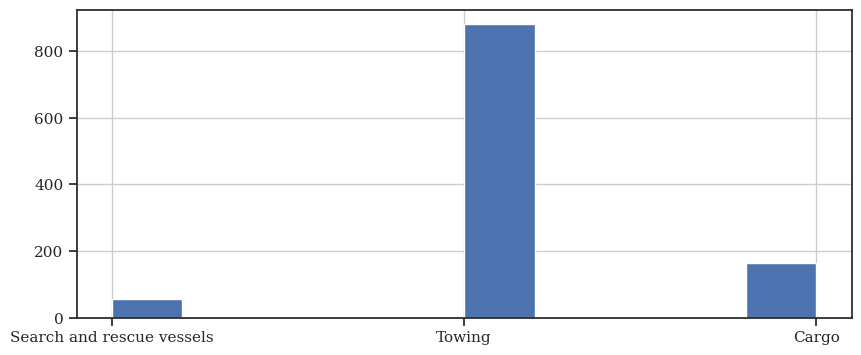

In [55]:
df_results["type"].hist()
pass

In [ ]:
# For identifying interesting cases
with_benefit = df_results.copy()[(df_results["tau"] >= 1.0) | (df_results["tau"] == 0.0)]

with_benefit = (
    with_benefit.groupby("mmsi")
    .apply(
        lambda group: group.copy()[
            (
                (group["tau"] == 0.0)
                | (
                    (group["tau"] > 0.0)
                    & (
                        # The best in the group
                        group["pos_error_mean"]
                        == group[group["tau"] != 0.0]["pos_error_mean"].min()
                    )
                )
            )
            # # TODO: for the interesting cases
            # & (group["pos_error_mean"] < group["pos_error_mean"].quantile(0.3).item())
        ]
        .assign(
            benefit=(
                group[group["tau"] == 0.0]["pos_error_mean"].item()
                - group[group["tau"] != 0.0]["pos_error_mean"].min()
            )
        )
        .assign(
            relative_error=(
                group["pos_error_mean"] / group[group["tau"] == 0.0]["pos_error_mean"].item()
            )
        )
        .sort_values("tau"),
        include_groups=False,
    )
    .droplevel(1, axis="index")
)

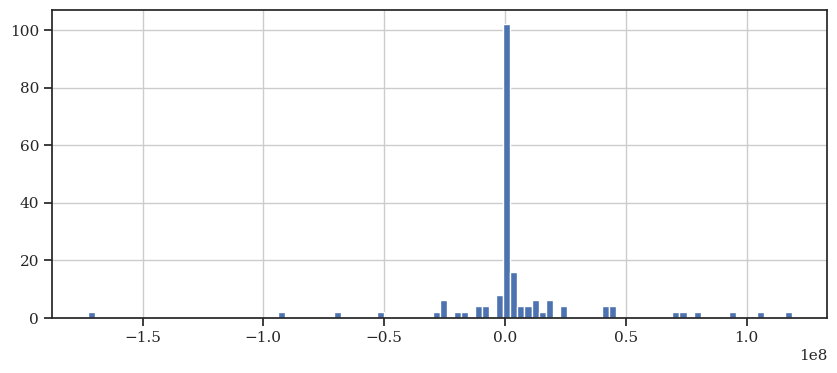

In [58]:
with_benefit["benefit"].hist(bins=100)
pass

In [59]:
with_benefit_strong = with_benefit[with_benefit["benefit"] > 0]

only_tau_nonzero = with_benefit_strong[with_benefit_strong["tau"] != 0.0]
decent_mmsis = only_tau_nonzero[
    (only_tau_nonzero["relative_error"].quantile(0.8).item() < only_tau_nonzero["relative_error"])
    & (only_tau_nonzero["relative_error"] < only_tau_nonzero["relative_error"].quantile(0.9).item())
].index.unique()
with_benefit_strong = with_benefit_strong[with_benefit_strong.index.isin(decent_mmsis)]

results_mmsis = with_benefit_strong.index.unique()
len(results_mmsis)

5

In [60]:
chosen_mmsi = results_mmsis[0]
results = with_benefit_strong.loc[chosen_mmsi].sort_values("tau")

assert len(results) == 2
assert results["tau"].iloc[0] == 0.0
assert results["tau"].iloc[1] > 0.0
result_pf, result_cofi = results.iloc[0], results.iloc[1]
weights = result_cofi["weights"]

print(f"mmsi: {chosen_mmsi} @ tau: {results['tau'].iloc[1]}")

result_cofi_all_taus = df_results[df_results["mmsi"] == chosen_mmsi]

(
    result_pf["pos_error_mean"].item(),
    result_cofi["pos_error_mean"].item(),
    result_cofi["benefit"].item(),
    result_cofi["relative_error"].item(),
)

mmsi: 366962130 @ tau: 1.0


(4207482.0687188385, 3499828.96697912, 707653.1017397186, 0.8318107860753887)

In [61]:
# # Show how the weights change over time
# for i in range(50):
#     plt.plot(weights[:, i])
# plt.show()
# plt.clf()

In [ ]:
plt.figure(figsize=(12, 10))
bg = landscape.scatter(alpha=0.5, plot_basemap=False)
plot_trajectories(result_pf["truth"][:, :2], label="True trajectory")
plot_trajectories(result_pf["estimates"][:, :2], label="Estimated trajectory (PF)")
plot_trajectories(result_cofi["estimates"][:, :2], label="Estimated trajectory (CoFi)")

# Mark the starting point
plt.plot(
    result_pf["truth"][0, 0],
    result_pf["truth"][0, 1],
    marker=ship_marker,
    markersize=10,
    color="black",
    label="Start",
)

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

all_coords = np.concatenate(
    [result_pf["truth"][:, :2], result_pf["estimates"][:, :2], result_cofi["estimates"][:, :2]]
)
scale = 1.0
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)
plt.gca().set_aspect("equal")

# Move legend to the right of the plot
plt.legend()
# move_legend(plt.gca(), loc="center left", bbox_to_anchor=(1.3, 0.5))

plt.colorbar(bg)
pass

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

start = 119
end = 131
length = end - start

# taus = sorted(set(df_results["tau"].unique()) - {0.0})
taus = [0.1, 0.5, 1.0]

all_result_cofi = {
    tau: result_cofi_all_taus[
        (result_cofi_all_taus["mmsi"] == chosen_mmsi)
        & ((result_cofi_all_taus["tau"] - tau).abs() < 1e-6)
    ].iloc[0]
    for tau in taus
}

c_true = sns.color_palette("tab10")[2]
c_pf = sns.color_palette("tab10")[4]
c_cofi = sns.color_palette("tab10")[1]

cofi_alphas = {
    0.1: 0.3,
    0.5: 0.6,
    1.0: 1.0,
}


def plot_trajectories_(all_positions: ndarray, label: str | None, **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        return axes[0].plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)


# bg = landscape.scatter(alpha=0.5, plot_basemap=True, zoom=14)
axes[0].imshow(
    landscape.values().reshape((200, 200)),
    origin="lower",
    extent=landscape.extent(),
    cmap="coolwarm_r",
    alpha=0.5,
    rasterized=False,  # Because the extend is not large
    interpolation="bicubic",
)

lw = 3
(line_track_true,) = plot_trajectories_(
    result_pf["truth"][start:end, :2],
    label="True Trajectory",
    lw=lw,
    marker="+",
    markersize=15,
    color=c_true,
)
(line_track_pf,) = plot_trajectories_(
    result_pf["estimates"][start:end, :2],
    label="Estimate (Particle Filter)",
    lw=lw,
    marker="1",
    markersize=15,
    color=c_pf,
)
line_tracks_cofi = []
for tau in taus:
    (line,) = plot_trajectories_(
        all_result_cofi[tau]["estimates"][start:end, :2],
        label=rf"Estimate (CoFi) @ $\tau={tau}$",
        lw=lw,
        marker="x",
        markersize=15,
        color=c_cofi,
        alpha=cofi_alphas[tau],
    )
    line_tracks_cofi.append(line)

# Annotate the steps in the ground thruth
for i in range(start, end):
    axes[0].scatter(
        result_cofi["particles"][i, :, 0],
        result_cofi["particles"][i, :, 1],
        color="black",
        alpha=0.2,
        s=0.5,
    )

axes[0].set_xlabel("Easting / m")
axes[0].set_ylabel("Northing / m")
axes[0].set_xlim(-7000, -5000)
axes[0].set_ylim(-5000, 0)
axes[0].set_aspect("equal")
axes[0].legend()

time_scale = 60.0
time_steps = np.arange(length) * time_scale
err_pf = np.linalg.norm(
    result_pf["truth"][start:end, :2] - result_pf["estimates"][start:end, :2], axis=1
)
(line_pf_error,) = axes[1].plot(
    time_steps,
    err_pf,
    label="Particle Filter",
    color=c_pf,
    lw=2,
)
errs_cofi = []
line_err_cofi = []
for tau in taus:
    err_cofi = np.linalg.norm(
        result_cofi["truth"][start:end, :2] - all_result_cofi[tau]["estimates"][start:end, :2],
        axis=1,
    )
    errs_cofi.append(err_cofi)
    (line,) = axes[1].plot(
        time_steps,
        err_cofi,
        label=rf"CoFi @ $\tau={tau}$",
        alpha=cofi_alphas[tau],
        color=c_cofi,
        lw=2,
    )
    line_err_cofi.append(line)

axes[1].set_xticks(time_steps)
axes[1].set_xlim(time_steps.min(), time_steps.max())
axes[1].set_xlabel("Time / s")
axes[1].set_ylabel("Tracking Error / m")
# axes[1].legend()


def update(num):
    line_track_true.set_data(
        result_pf["truth"][start : min(end, start + num + 1), 0],
        result_pf["truth"][start : min(end, start + num + 1), 1],
    )
    line_track_pf.set_data(
        result_pf["estimates"][start : min(end, start + num + 1), 0],
        result_pf["estimates"][start : min(end, start + num + 1), 1],
    )
    line_pf_error.set_data(time_steps[: num + 1], err_pf[: num + 1])
    for i, (tau, line_track, line_err) in enumerate(zip(taus, line_tracks_cofi, line_err_cofi)):
        # make sure that the old tau thing stay shown
        if (len(taus) - i) * length <= num:
            l_num = length
        else:
            l_num = num % length

        line_track.set_data(
            all_result_cofi[tau]["estimates"][start : min(end, start + l_num + 1), 0],
            all_result_cofi[tau]["estimates"][start : min(end, start + l_num + 1), 1],
        )
        err_cofi = errs_cofi[taus.index(tau)]
        line_err.set_data(time_steps[: l_num + 1], err_cofi[: l_num + 1])

    return (line_track_true, line_track_pf, line_pf_error, *line_tracks_cofi, *line_err_cofi)


ani = FuncAnimation(
    fig,
    update,
    length * len(taus),
    # fargs=[positions[:, 0], positions[:, 1], line],
    interval=100,
    blit=True,
)
ani.save("for_video.gif")
# ani.save("for_video.mp4")
plt.clf()

plt.subplots_adjust(wspace=0)

pass

In [ ]:
plt.plot(errs_cofi[2] / err_pf)

In [ ]:
1 - (errs_cofi[2] / err_pf).mean().item()

### Visualize using Kepler.gl

In [67]:
def cartesian_to_polar(coords: ndarray) -> ndarray:
    collection = CartesianCollection(origin=origin, number_of_values=1)
    collection.append_with_default(coords, np.nan)
    return collection.to_polar().coordinates()


def make_line_string(cartesian_coords: ndarray) -> str:
    return json.dumps(
        {
            "type": "LineString",
            "coordinates": cartesian_to_polar(cartesian_coords).tolist(),
        }
    )


start_date = "2023-08-01 0:0:00"
date_format = "%Y-%m-%d %X"


def make_route_points(cartesian_coords: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, 2)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                    },
                }
                for coord, time in zip(
                    cartesian_to_polar(cartesian_coords),
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
            ],
        }
    )


def make_particles(cartesian_coords: ndarray, weights: ndarray) -> str:
    """

    Args:
        cartesian_coords: Shape (T, N, 2)
        weights: Shape (T, N)
    """
    return json.dumps(
        {
            "type": "FeatureCollection",
            "features": [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord.tolist(),
                    },
                    "properties": {
                        "timestamp": time,
                        "weight": weight,
                    },
                }
                for coords_t, weights_t, time in zip(
                    cartesian_coords,
                    weights,
                    pd.date_range(start=start_date, periods=cartesian_coords.shape[0]).strftime(
                        date_format
                    ),
                )
                for coord, weight in zip(
                    cartesian_to_polar(coords_t),
                    weights_t.tolist(),
                )
            ],
        }
    )

In [ ]:
subsample_particles = 4
map = KeplerGl(
    data={
        "True Trajectory Track": make_line_string(result_pf["truth"][:, :2]),
        "True Trajectory": make_route_points(result_pf["truth"][:, :2]),
        #
        "Estimated Trajectory (CoFi) Track": make_line_string(result_cofi["estimates"][:, :2]),
        "Estimated Trajectory (CoFi)": make_route_points(result_cofi["estimates"][:, :2]),
        #
        "Estimated Trajectory (PF) Track": make_line_string(result_pf["estimates"][:, :2]),
        "Estimated Trajectory (PF)": make_route_points(result_pf["estimates"][:, :2]),
        #
        "Particles (PF)": make_particles(
            result_pf["particles"][:, :subsample_particles, :2],
            weights=result_pf["weights"][:, :subsample_particles],
        ),
        "Particles (CoFi)": make_particles(
            result_cofi["particles"][:, :subsample_particles, :2],
            weights=result_cofi["weights"][:, :subsample_particles],
        ),
    },
    config={
        "version": "v1",
        "config": {
            "mapState": {
                "latitude": cartesian_to_polar(all_coords)[:, 1].mean(),
                "longitude": cartesian_to_polar(all_coords)[:, 0].mean(),
                "zoom": 11,
            },
            "visState": {
                "filters": [
                    {
                        "dataId": [data_field],
                        "id": f"94q7ipgwi-{data_field}",
                        "name": ["timestamp"],
                        "type": "DateTime",
                        "yAxis": None,
                        "speed": 0.2,
                    }
                    for data_field in [
                        "True Trajectory",
                        "Estimated Trajectory (CoFi)",
                        "Estimated Trajectory (PF)",
                        "Particles (PF)",
                        "Particles (CoFi)",
                    ]
                ]
            },
        },
    },
)
# map.save_to_html(file_name="visualize_results.html")
map

You can now invoke `show-html.py` to serve the HTML file.

### Visualize the results with matplotlib

In [69]:
res_ = []
for vessel_type in interpolators:
    df_ = df[df["VesselTypeName"] == vessel_type]
    points = df_[["East", "North"]].values
    c = interpolators[vessel_type](points)
    for value in c:
        res_.append(
            {
                "Vessel Type": vessel_type,
                "Constitutional": value.item(),
            }
        )

res_df = pd.DataFrame(res_)
del res_
res_df

,Vessel Type,Constitutional
0,Cargo,0.855000
1,Cargo,0.855000
2,Cargo,0.855000
3,Cargo,0.855000
4,Cargo,0.855000
...,...,...
43583,Towing,0.063174
43584,Towing,0.060033
43585,Towing,0.059731
43586,Towing,0.060372


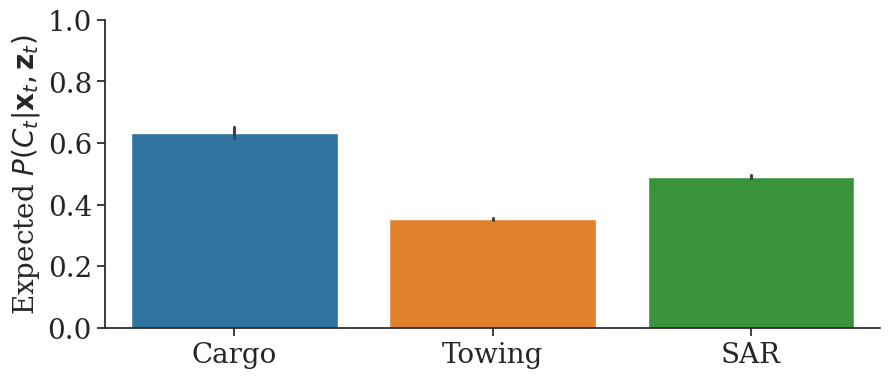

In [70]:
sns.barplot(
    data=res_df.replace({"Vessel Type": {"Search and rescue vessels": "SAR"}}),
    x="Vessel Type",
    y="Constitutional",
    hue="Vessel Type",
    order=["Cargo", "Towing", "SAR"],
    hue_order=["Cargo", "Towing", "SAR"],
    palette=sns.color_palette("tab10")[:3],
)
sns.despine()
plt.ylabel(r"Expected $P(C_t | \mathbf{x}_t, \mathbf{z}_t)$", size=20)
plt.xlabel("")
plt.ylim(0, 1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plot_put = output_folder / "plots"
plot_put.mkdir(exist_ok=True)
plt.savefig(plot_put / "ais-constitution.pdf", bbox_inches="tight")
pass

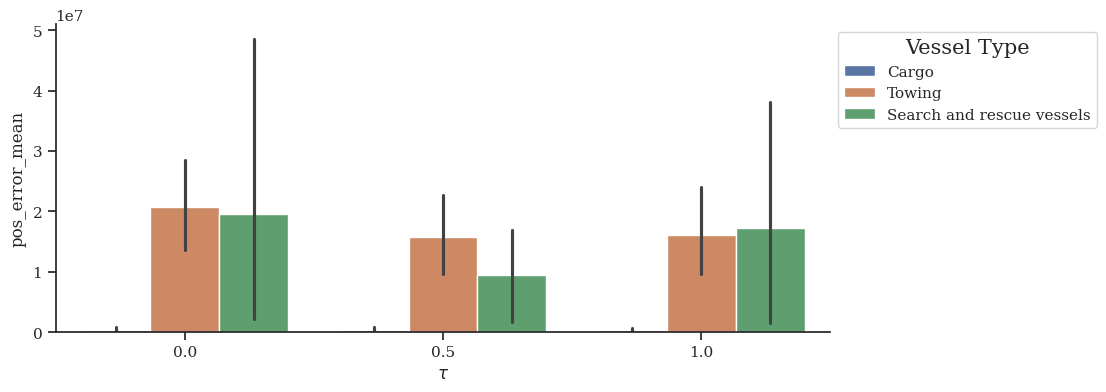

In [71]:
df_results_export = df_results.copy()[
    ["mmsi", "type", "tau", "seed", "pos_error_mean", "all_error_mean"]
]
df_results_export.to_csv(output_folder / "res-all-taus.csv", index=False)

df_renamed = df_results_export.rename(
    columns={
        "type": "Vessel Type",
        "tau": r"$\tau$",
    }
)

df_ = df_renamed.copy()
sns.barplot(
    x=r"$\tau$",
    y="pos_error_mean",
    hue="Vessel Type",
    data=df_[df_[r"$\tau$"].isin([0.0, 0.5, 1.0])],
    hue_order=["Cargo", "Towing", "Search and rescue vessels"],
)

# move the legend outside
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

sns.despine()

plt.savefig(plot_put / "relative_position_error.pdf", bbox_inches="tight")
pass

In [72]:
df_renamed["Vessel Type"].value_counts()

Vessel Type
Towing                       880
Cargo                        165
Search and rescue vessels     55
Name: count, dtype: int64

In [73]:
type_wise_data = []

for type in df_renamed["Vessel Type"].unique():
    type_data = df_renamed[df_renamed["Vessel Type"] == type].copy()
    type_data["Relative Position Error"] = (
        type_data["pos_error_mean"] / type_data["pos_error_mean"][type_data[r"$\tau$"] == 0]
    )
    type_wise_data.append(type_data)

normalized_data_per_type = pd.concat(type_wise_data)

In [74]:
aggregated_data = []

for mmsi in df_renamed["mmsi"].unique():
    mmsi_data = df_renamed[df_renamed["mmsi"] == mmsi].copy()
    mmsi_data[r"Best $\tau$"] = mmsi_data[
        mmsi_data["pos_error_mean"] == mmsi_data["pos_error_mean"].min()
    ][r"$\tau$"].iloc[0]
    mmsi_data["Relative Position Error"] = (
        mmsi_data["pos_error_mean"] / mmsi_data["pos_error_mean"][mmsi_data[r"$\tau$"] == 0].item()
    )
    aggregated_data.append(mmsi_data)

normalized_to_pf = pd.concat(aggregated_data)
normalized_to_pf

,mmsi,Vessel Type,$\tau$,seed,pos_error_mean,all_error_mean,Best $\tau$,Relative Position Error
0,368111580,Search and rescue vessels,0.0,2023,7.756023e+07,7.756023e+07,0.1,1.000000
1,368111580,Search and rescue vessels,0.1,2023,6.560513e+06,6.560513e+06,0.1,0.084586
2,368111580,Search and rescue vessels,0.2,2023,7.831044e+06,7.831044e+06,0.1,0.100967
3,368111580,Search and rescue vessels,0.3,2023,2.182914e+07,2.182914e+07,0.1,0.281448
4,368111580,Search and rescue vessels,0.4,2023,1.550461e+07,1.550461e+07,0.1,0.199904
...,...,...,...,...,...,...,...,...
1095,565565000,Cargo,0.6,2023,8.521922e+01,8.612133e+01,0.0,1.538771
1096,565565000,Cargo,0.7,2023,8.965442e+01,9.053325e+01,0.0,1.618856
1097,565565000,Cargo,0.8,2023,8.525719e+01,8.614562e+01,0.0,1.539457
1098,565565000,Cargo,0.9,2023,8.836533e+01,8.912667e+01,0.0,1.595579


In [75]:
historgram = normalized_to_pf[r"Best $\tau$"].value_counts(normalize=True).sort_index() * 100
historgram

Best $\tau$
0.0    23.0
0.1     9.0
0.2    11.0
0.3     7.0
0.4     7.0
0.5     8.0
0.6     8.0
0.7     8.0
0.8     5.0
0.9     7.0
1.0     7.0
Name: proportion, dtype: float64

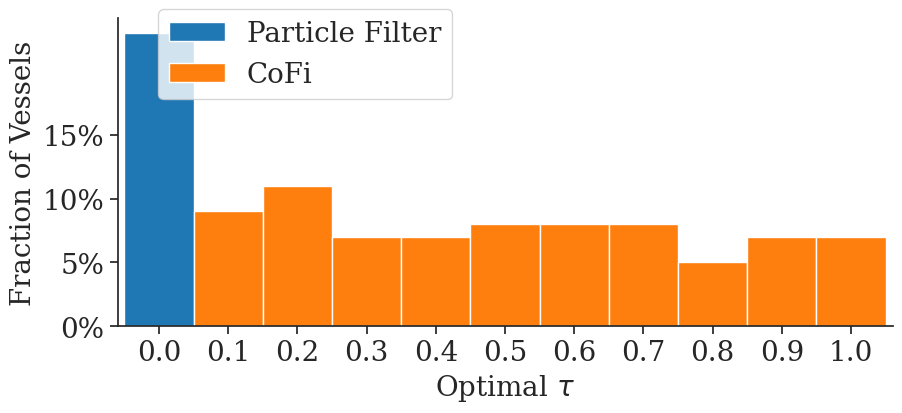

In [76]:
# plt.title("Distribution of optimal taus")
plt.bar(
    historgram.index,
    historgram.values,
    width=0.1,
    color=[sns.color_palette("tab10")[0]] + [sns.color_palette("tab10")[1]] * 10,
)

plt.xlabel(r"Optimal $\tau$", size=20)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xticks(fontsize=20)

from matplotlib.ticker import PercentFormatter

plt.ylabel("Fraction of Vessels", size=20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.yticks(fontsize=20)
plt.yticks(ticks=range(0, 16, 5))

from matplotlib.patches import Patch

plt.legend(
    handles=[
        Patch(facecolor=sns.color_palette("tab10")[0], label="Particle Filter"),
        Patch(facecolor=sns.color_palette("tab10")[1], label="CoFi"),
    ],
    fontsize=20,
    bbox_to_anchor=(0.45, 1.075),
    loc="upper right",
)

sns.despine()

plt.xlim(-0.06, 1.06)

plt.savefig(plot_put / "optimal-taus.pdf", bbox_inches="tight")

pass

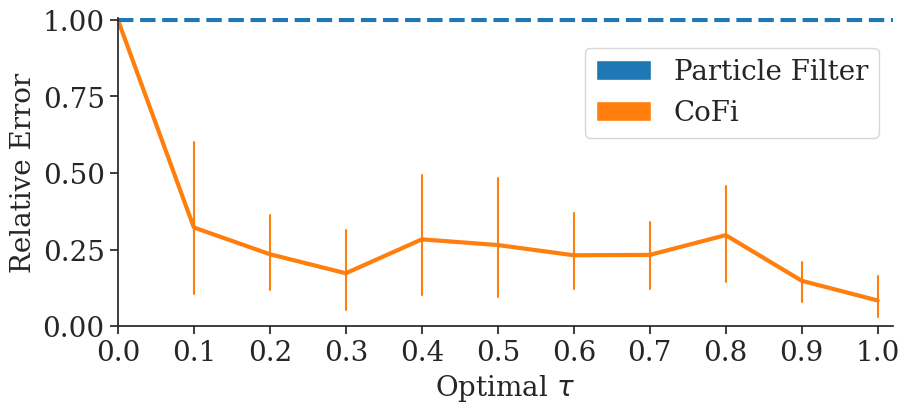

In [80]:
df_ = normalized_to_pf.copy()
df_ = df_[(df_[r"Best $\tau$"] == df_[r"$\tau$"]) | (df_[r"$\tau$"] == 0.0)]

sns.lineplot(
    df_,
    x=r"$\tau$",
    y="Relative Position Error",
    err_style="bars",
    errorbar="ci",
    lw=3,
    color=sns.color_palette("tab10")[1],
)

plt.axhline(1, c=sns.color_palette("tab10")[0], ls="--", lw=3)

plt.xlim(0, 1.02)
plt.ylim(0, 1.005)
sns.despine()

plt.legend(
    handles=[
        Patch(facecolor=sns.color_palette("tab10")[0], label="Particle Filter"),
        Patch(facecolor=sns.color_palette("tab10")[1], label="CoFi"),
    ],
    fontsize=20,
    bbox_to_anchor=(1, 0.95),
    loc="upper right",
)

plt.xticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xlabel(r"Optimal $\tau$", size=20)

plt.yticks(np.arange(0, 1.1, 0.25), fontsize=20)
plt.ylabel("Relative Error", size=20)

plt.savefig(plot_put / "relative_position_error_best_tau.pdf", bbox_inches="tight")
pass

In [ ]:
ax = sns.lineplot(
    x=r"$\tau$",
    y="Relative Position Error",
    # hue="Vessel Type",
    hue=r"Best $\tau$",
    data=normalized_to_pf,
    errorbar=None,
)
plt.axhline(1, c="black", ls="--", lw=1, label="Particle Filter")
# plt.legend(title="Vessel Type", loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
sns.despine()
pass

In [85]:
res = []
for mmis in df_results["mmsi"].unique():
    df_ = df_results[df_results["mmsi"] == mmis]
    # sort by tau
    df_ = df_.sort_values("pos_error_mean")
    res.append((df_["type"].iloc[0], df_["tau"].iloc[0]))

res = pd.DataFrame(res, columns=["Vessel Type", r"$\tau$"])
# Rname Search and rescue vessels to SAR
res["Vessel Type"] = res["Vessel Type"].replace("Search and rescue vessels", "SAR")
res

,Vessel Type,$\tau$
0,SAR,0.1
1,Towing,0.6
2,Towing,0.4
3,Towing,0.0
4,Towing,0.7
...,...,...
95,Cargo,0.0
96,Cargo,0.0
97,SAR,0.0
98,Cargo,0.0


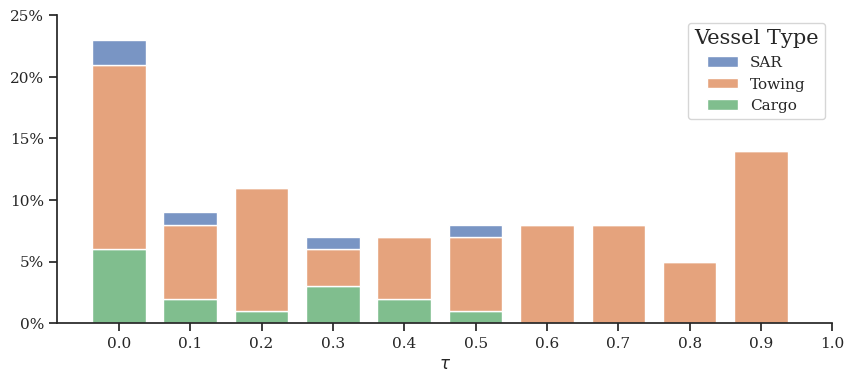

In [86]:
r_ = res.copy()

# r_["Vessel Type"] = "All"
# res_ = pd.concat([res, r_], axis=0)
# res_.sort_values("Vessel Type", inplace=True)

sns.histplot(
    r_,
    x=r"$\tau$",
    hue="Vessel Type",
    multiple="stack",
    bins=10,
    stat="percent",
    shrink=0.75,
    # palette="colorblind",
)

plt.ylabel("")
plt.yticks(plt.yticks()[0], [f"{i.get_text()}%" for i in plt.yticks()[1]])
sns.despine()

# Fix the placmenet of the x-axis
plt.xticks(np.arange(0, 1.1, 0.1) + 0.05, [f"{i:.1f}" for i in np.arange(0, 1.1, 0.1)])

plt.savefig(output_folder / "tau-distribution.pdf", bbox_inches="tight")

pass